Binary 1/6 B)


mRNA localization using binary classification (cytoplasm/endoplasmic reticulum) (part 1/2): basic model with: <br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 4: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance), threshold 0 <br>
c) Method 5: with feature importance-based feature selection (feature importance type: SHAP values), threshold > 0

In [2]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [4]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Endoplasmic reticulum (label = 1)
ER_train = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_train_CSV.csv")
ER_test = pd.read_csv("../../Data/InputData/ER_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("ER TRAIN, TEST SHAPE:", ER_train.shape, ",", ER_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
ER TRAIN, TEST SHAPE: (296, 1026) , (74, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:
#Group 1: CP + ER

frames_EC_tra = [CP_train, ER_train]
frames_EC_tes = [CP_test, ER_test]

CP_ER_train = pd.concat(frames_EC_tra)
CP_ER_test = pd.concat(frames_EC_tes)



In [6]:
print("CP + ER TRAIN, TEST SHAPE:", CP_ER_train.shape, ",", CP_ER_test.shape)


CP + ER TRAIN, TEST SHAPE: (1120, 1026) , (280, 1026)


In [7]:
CP_ER_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_9547#3911|1|testing,1,0.001311,0.000087,0.000262,0.000262,0.000000,0.000437,0.000175,0.000175,...,0.000087,0.000262,0.000175,0.000262,0.001224,0.000612,0.000175,0.000087,0.000175,0.000175
1,mRNALoc_11948#55102|1|testing,1,0.002614,0.000991,0.001893,0.003245,0.001532,0.000811,0.000541,0.001532,...,0.000180,0.002614,0.001442,0.001712,0.002073,0.001532,0.003335,0.002704,0.002524,0.003064


In [8]:
#Remove name/symbol column and separate labels and variables from training and testing data

#FOR CP+ER
noname_CE_train = CP_ER_train.drop("#", axis="columns")
noname_CE_test = CP_ER_test.drop("#", axis="columns")


CP_ER_X_train = noname_CE_train.drop("label", axis="columns")
CP_ER_y_train = noname_CE_train["label"]

CP_ER_X_test = noname_CE_test.drop("label", axis="columns")
CP_ER_y_test = noname_CE_test["label"]

print("CP + ER X train:", CP_ER_X_train.shape)
print("CP + ER y train:", CP_ER_y_train.shape)
print("CP + ER X test:", CP_ER_X_test.shape)
print("CP + ER y test:", CP_ER_y_test.shape)

CP + ER X train: (1120, 1024)
CP + ER y train: (1120,)
CP + ER X test: (280, 1024)
CP + ER y test: (280,)


In [9]:
# Create data pools for feature importance/selection for CP + ER

CE_feature_names = list(CP_ER_X_train.columns)
print("Number of features:", len(CE_feature_names))

CE_train_pool = Pool(CP_ER_X_train, CP_ER_y_train, feature_names=CE_feature_names)

CE_test_pool = Pool(CP_ER_X_test, CP_ER_y_test)

print("*Cytoplasm, ER Pools created")

Number of features: 1024
*Cytoplasm, ER Pools created


    Method 1: Initial classification (without feature importance, selection, hyperparameter tuning or auto_class_weights)

In [10]:
CE_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to CE data

CE_binary_model.fit(CE_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6700853	total: 223ms	remaining: 3m 42s
1:	learn: 0.6515013	total: 338ms	remaining: 2m 48s
2:	learn: 0.6342181	total: 480ms	remaining: 2m 39s
3:	learn: 0.6196763	total: 593ms	remaining: 2m 27s
4:	learn: 0.6041872	total: 713ms	remaining: 2m 21s
5:	learn: 0.5892435	total: 829ms	remaining: 2m 17s
6:	learn: 0.5736680	total: 944ms	remaining: 2m 13s
7:	learn: 0.5625873	total: 1.06s	remaining: 2m 10s
8:	learn: 0.5530769	total: 1.18s	remaining: 2m 9s
9:	learn: 0.5418085	total: 1.31s	remaining: 2m 9s
10:	learn: 0.5336489	total: 1.42s	remaining: 2m 7s
11:	learn: 0.5259600	total: 1.54s	remaining: 2m 6s
12:	learn: 0.5181220	total: 1.66s	remaining: 2m 6s
13:	learn: 0.5106922	total: 1.78s	remaining: 2m 5s
14:	learn: 0.5033874	total: 1.9s	remaining: 2m 4s
15:	learn: 0.4969499	total: 2.01s	remaining: 2m 3s
16:	learn: 0.4915303	total: 2.13s	remaining: 2m 2s
17:	learn: 0.4867163	total: 2.25s	remaining: 2m 2s
18:	learn: 0.4829952	total: 2.37s	remaining: 2m 2s
19:	

In [12]:
#Check parameters used in this model fit

CE_bin_params = CE_binary_model.get_all_params()
print("Basic model parameters:", CE_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [13]:
#Prediction using X_test
CE_y_pred = CE_binary_model.predict(CP_ER_X_test)

#Predication probability

CE_y_prob = CE_binary_model.predict_proba(CP_ER_X_test)

In [14]:
# Calculate F1 score and get classification report

CE_f1 = f1_score(CP_ER_y_test, CE_y_pred, average='macro')
print(f"F1 Score: {CE_f1}")

CE_cr = classification_report(CP_ER_y_test, CE_y_pred, digits=3)
print(CE_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_y_prob))

F1 Score: 0.5416024653312789
              precision    recall  f1-score   support

           0      0.759     0.981     0.856       206
           1      0.714     0.135     0.227        74

    accuracy                          0.757       280
   macro avg      0.737     0.558     0.542       280
weighted avg      0.747     0.757     0.690       280

Accuracy score:  0.7571428571428571


In [15]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_y_pred.shape)

CE_y_pred_fl = CE_y_pred
print("flattened prediction values shape:", CE_y_pred_fl.ravel().shape, "\n")

CE_cMatrix = confusion_matrix(CP_ER_y_test, CE_y_pred_fl)
print(CE_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[202   4]
 [ 64  10]]


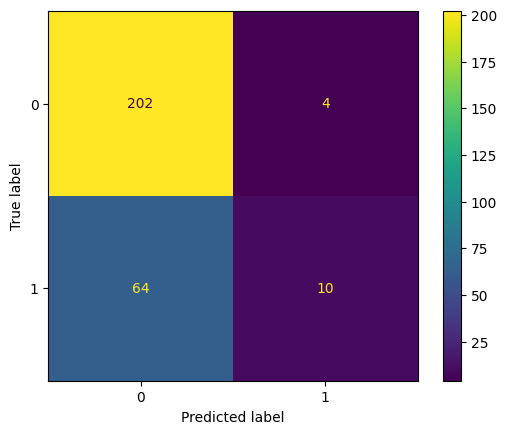

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_cMatrix, display_labels=CE_binary_model.classes_)
disp.plot()
plt.show()

    Method 4: Feature importance-based feature selection with threshold: > 0

In [17]:
#Feature importances for CE pair

CE_feat_importances = CE_binary_model.get_feature_importance(prettified=True)
CE_feat_importances.head(100)

,Feature Id,Importances
0,TCGAA,1.892877
1,TCTCG,1.405180
2,CTTAG,1.263258
3,CTGGT,1.112860
4,AGAAG,0.956090
...,...,...
95,AAGTC,0.224529
96,TCGGA,0.223918
97,CATAT,0.223686
98,GGCTA,0.223391


In [18]:
# Show only feature importances above 0.1

threshold_chosen_features = CE_feat_importances[CE_feat_importances['Importances'] > 0]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0 (selected features):", num_chosen_features)

    Feature Id  Importances
0        TCGAA     1.892877
1        TCTCG     1.405180
2        CTTAG     1.263258
3        CTGGT     1.112860
4        AGAAG     0.956090
..         ...          ...
982      TGTTT     0.001000
983      CAGCT     0.000830
984      GGCTC     0.000721
985      TAAAG     0.000398
986      AGGCG     0.000099

[987 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 987


In [19]:
print("Sum of total feature importances: ", sum(CE_feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999991
Sum of feature importances > 0:  99.99999999999991


In [20]:
# Select features with importance values above 0.1

CE_selected_feat = CE_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(CE_selected_feat)

In [21]:
CP_ER_X_train.shape

(1120, 1024)

In [22]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [23]:
#Create training set with selected features 

CE_X_train_selected = CP_ER_X_train[CE_selected_feat]
CE_X_train_selected.head()

,TCGAA,TCTCG,CTTAG,CTGGT,AGAAG,TGGTG,CAAGC,TTTGC,GGGTT,TGAAG,...,TAGCG,CGCTG,CAGGC,AAATT,TTTTA,TGTTT,CAGCT,GGCTC,TAAAG,AGGCG
0,0.000158,0.000792,0.000475,0.000634,0.001742,0.001109,0.001426,0.001109,0.000475,0.002376,...,0.000000,0.000950,0.000317,0.001901,0.001584,0.002218,0.001901,0.000475,0.001742,0.000475
1,0.000583,0.000583,0.000000,0.000874,0.004079,0.001748,0.000583,0.000291,0.000291,0.000874,...,0.000000,0.000583,0.001748,0.000000,0.000291,0.000583,0.001457,0.003788,0.000291,0.001166
2,0.000458,0.000458,0.000917,0.001375,0.002291,0.001375,0.000458,0.000458,0.000917,0.000458,...,0.000458,0.001375,0.003208,0.000458,0.000917,0.001833,0.003208,0.001833,0.000917,0.000000
3,0.000000,0.000000,0.000990,0.000495,0.000990,0.001484,0.001484,0.000000,0.000990,0.000495,...,0.000000,0.000495,0.002969,0.000495,0.000495,0.000495,0.002474,0.002474,0.000000,0.001484
4,0.000104,0.000415,0.000933,0.000415,0.001659,0.001451,0.000933,0.000933,0.001555,0.001451,...,0.000000,0.000104,0.000933,0.002695,0.002695,0.003524,0.002281,0.000726,0.001244,0.000311


In [24]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_selected.columns) == CE_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [25]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 987)
Shape of y_train (number of labels): (1120,)


In [26]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_selected_feat))

CE_selected_train_pool = Pool(CE_X_train_selected, CP_ER_y_train, feature_names=CE_selected_feat)

Original number of features: 1024 
 Number of selected features: 987


In [27]:
#Create new model for data with selected features
CE_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CE_FIFS_model.fit(CE_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6731118	total: 133ms	remaining: 2m 13s
1:	learn: 0.6513219	total: 259ms	remaining: 2m 9s
2:	learn: 0.6311949	total: 382ms	remaining: 2m 6s
3:	learn: 0.6139297	total: 501ms	remaining: 2m 4s
4:	learn: 0.5970179	total: 622ms	remaining: 2m 3s
5:	learn: 0.5834543	total: 736ms	remaining: 2m 1s
6:	learn: 0.5703045	total: 855ms	remaining: 2m 1s
7:	learn: 0.5585577	total: 977ms	remaining: 2m 1s
8:	learn: 0.5474384	total: 1.1s	remaining: 2m 1s
9:	learn: 0.5378108	total: 1.22s	remaining: 2m
10:	learn: 0.5269304	total: 1.34s	remaining: 2m
11:	learn: 0.5166272	total: 1.46s	remaining: 2m
12:	learn: 0.5075510	total: 1.58s	remaining: 1m 59s
13:	learn: 0.4989877	total: 1.69s	remaining: 1m 58s
14:	learn: 0.4927788	total: 1.81s	remaining: 1m 58s
15:	learn: 0.4866735	total: 1.92s	remaining: 1m 58s
16:	learn: 0.4776094	total: 2.05s	remaining: 1m 58s
17:	learn: 0.4723844	total: 2.16s	remaining: 1m 58s
18:	learn: 0.4659202	total: 2.28s	remaining: 1m 57s
19:	learn: 0.

In [28]:
#Check parameters used in this model fit

CE_FIFS_params = CE_FIFS_model.get_all_params()
print("Basic model parameters:", CE_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [29]:
#Prediction using X_test only for selected features data
CE_FIFS_y_pred = CE_FIFS_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_y_prob = CE_FIFS_model.predict_proba(CP_ER_X_test)

In [34]:
# Calculate F1 score and get classification report

print("Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - \n\t\t\t\tCytoplasm & endoplasmic reticulum")

print("Number of chosen features:", num_chosen_features, "\n")

CE_FIFS_cr = classification_report(CP_ER_y_test, CE_FIFS_y_pred, digits=3)
print(CE_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_y_pred))

CE_FIFS_f1 = f1_score(CP_ER_y_test, CE_FIFS_y_pred, average='macro')
print(f"\nF1 Score: {CE_FIFS_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_y_prob))

Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - 
				Cytoplasm & endoplasmic reticulum
Number of chosen features: 987 

              precision    recall  f1-score   support

           0      0.750     0.976     0.848       206
           1      0.583     0.095     0.163        74

    accuracy                          0.743       280
   macro avg      0.667     0.535     0.505       280
weighted avg      0.706     0.743     0.667       280

Accuracy score:  0.7428571428571429

F1 Score: 0.5054459817486017


In [35]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_y_pred.shape)

CE_FIFS_y_pred_fl = CE_FIFS_y_pred
print("flattened prediction values shape:", CE_FIFS_y_pred_fl.ravel().shape, "\n")

CE_FIFS_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_y_pred_fl)
print(CE_FIFS_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[201   5]
 [ 67   7]]


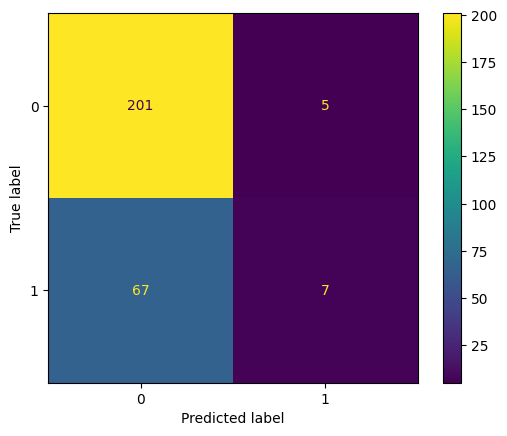

In [36]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_cMatrix, display_labels=CE_FIFS_model.classes_)
disp.plot()
plt.show()

*************

    Method 5: Modelling using feature selection based on feature importance values (SHAP Values), threshold > 0

In [37]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CE_binary_model)

In [38]:
#SHAP values for X_train
CE_shap_values = explainer.shap_values(CP_ER_X_train)

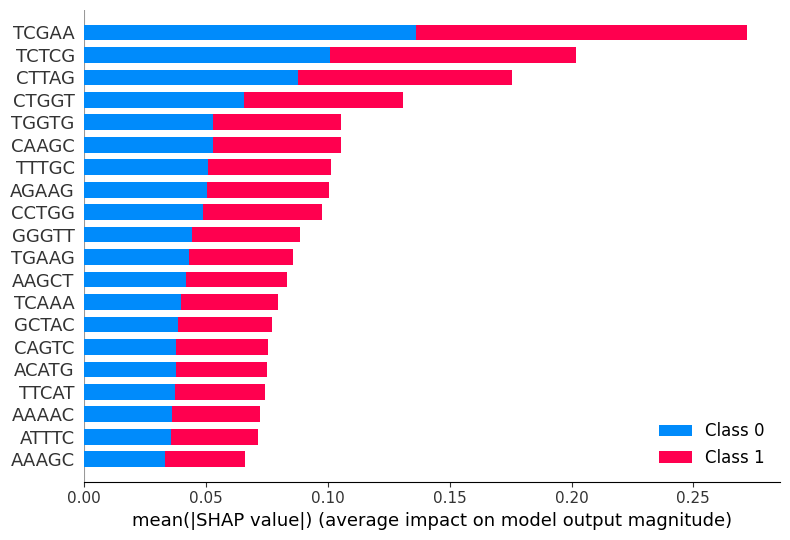

In [39]:
shap.summary_plot(CE_shap_values, CP_ER_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


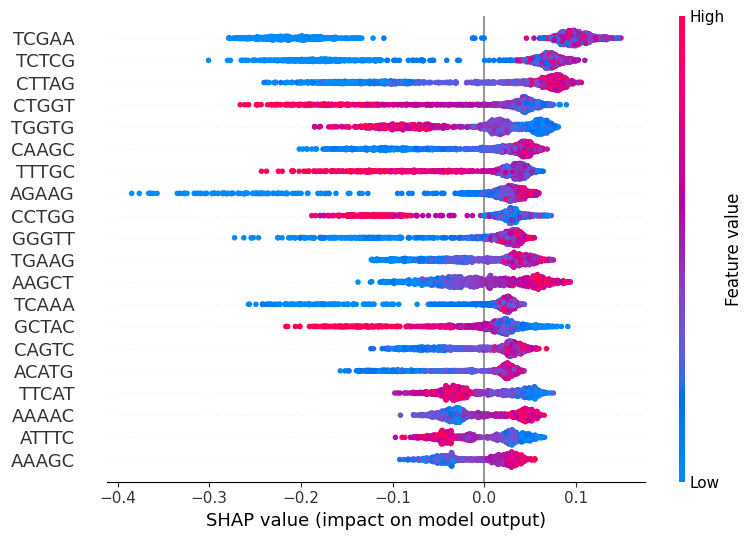

In [40]:
# Summary shap bar plot of Cytoplasm class (class 0)
shap.summary_plot(CE_shap_values[0], CP_ER_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


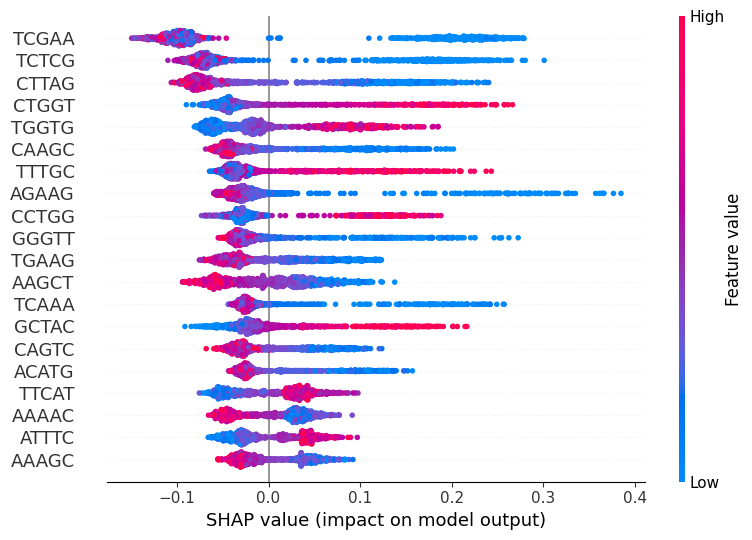

In [41]:
# Summary shap bar plot of Endoplasmic reticuum class (class 1)
shap.summary_plot(CE_shap_values[1], CP_ER_X_train, plot_size=0.2)

In [42]:
#Put values one one class into dataframe to use as reference values for FS
shap_df = pd.DataFrame(CE_shap_values[0], columns=CP_ER_X_train.columns)


In [43]:
# Calculate feature importance by only taking the values which 
CE_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [44]:
CE_shap_FI.head()

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,TCGAA,0.099348
1,TCTCG,0.069524
2,CTTAG,0.068141
3,GAGCC,0.048845
4,CTGGT,0.043455


In [45]:
# shap.summary_plot(CE_shap_values[0], CP_ER_X_train, show=False, max_display=30, plot_size=0.2)

In [46]:
#Classifier results with CE_feature_importance

In [47]:
# Show only feature importances above 0.1

CE_SHAP_thres_chosen = CE_shap_FI[CE_shap_FI['Importances'] > 0]
CE_shap_num_chosen = len(CE_SHAP_thres_chosen)

print(CE_SHAP_thres_chosen)

print("\nAmount of features with importance above 0 (selected features):", CE_shap_num_chosen)

    Feature Id  Importances
0        TCGAA     0.099348
1        TCTCG     0.069524
2        CTTAG     0.068141
3        GAGCC     0.048845
4        CTGGT     0.043455
..         ...          ...
982      GCAAC     0.000213
983      TTTTA     0.000192
984      CAGCT     0.000147
985      ATATG     0.000122
986      AGGCG     0.000022

[987 rows x 2 columns]

Amount of features with importance above 0 (selected features): 987


In [48]:
print("Sum of total feature importances: ", sum(CE_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(CE_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  5.178115138192292


In [49]:
# Select features with importance values above 0.1

CE_shap_selected_feat = CE_shap_FI[:CE_shap_num_chosen]['Feature Id'].tolist()

# print(CE_shap_selected_feat)

In [50]:
CP_ER_X_train.shape

(1120, 1024)

In [51]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [52]:
#Create training set with selected features 

CE_X_train_shap_selected = CP_ER_X_train[CE_shap_selected_feat]
CE_X_train_shap_selected.head()

,TCGAA,TCTCG,CTTAG,GAGCC,CTGGT,AAGCT,AAAAC,TTCAT,TGGTG,TCCAG,...,TTGCG,AAATT,TAACA,GACCG,TAAAG,GCAAC,TTTTA,CAGCT,ATATG,AGGCG
0,0.000158,0.000792,0.000475,0.001267,0.000634,0.001426,0.000792,0.000634,0.001109,0.001426,...,0.000317,0.001901,0.000634,0.000475,0.001742,0.001584,0.001584,0.001901,0.000792,0.000475
1,0.000583,0.000583,0.000000,0.002040,0.000874,0.000874,0.000291,0.001166,0.001748,0.003205,...,0.000291,0.000000,0.000291,0.001457,0.000291,0.000583,0.000291,0.001457,0.000583,0.001166
2,0.000458,0.000458,0.000917,0.003208,0.001375,0.000458,0.001375,0.000000,0.001375,0.004125,...,0.000000,0.000458,0.000917,0.000000,0.000917,0.000000,0.000917,0.003208,0.000458,0.000000
3,0.000000,0.000000,0.000990,0.000495,0.000495,0.000000,0.000990,0.000000,0.001484,0.002969,...,0.000000,0.000495,0.000000,0.000990,0.000000,0.001484,0.000495,0.002474,0.000000,0.001484
4,0.000104,0.000415,0.000933,0.001037,0.000415,0.001244,0.002488,0.001555,0.001451,0.001555,...,0.000104,0.002695,0.001037,0.000104,0.001244,0.001140,0.002695,0.002281,0.001762,0.000311


In [53]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_shap_selected.columns) == CE_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [54]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 987)
Shape of y_train (number of labels): (1120,)


In [55]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_shap_selected_feat))

CE_shap_selected_train_pool = Pool(CE_X_train_shap_selected, CP_ER_y_train, feature_names=CE_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 987


In [56]:
#Create new model for data with selected features
CE_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CE_FIFS_shap_model.fit(CE_shap_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6706680	total: 263ms	remaining: 4m 22s
1:	learn: 0.6496414	total: 429ms	remaining: 3m 33s
2:	learn: 0.6326631	total: 615ms	remaining: 3m 24s
3:	learn: 0.6159049	total: 764ms	remaining: 3m 10s
4:	learn: 0.5996198	total: 913ms	remaining: 3m 1s
5:	learn: 0.5842905	total: 1.04s	remaining: 2m 53s
6:	learn: 0.5702154	total: 1.17s	remaining: 2m 46s
7:	learn: 0.5584786	total: 1.3s	remaining: 2m 41s
8:	learn: 0.5475461	total: 1.43s	remaining: 2m 37s
9:	learn: 0.5371188	total: 1.59s	remaining: 2m 37s
10:	learn: 0.5277409	total: 1.75s	remaining: 2m 37s
11:	learn: 0.5173587	total: 1.9s	remaining: 2m 36s
12:	learn: 0.5097458	total: 2.03s	remaining: 2m 34s
13:	learn: 0.5014318	total: 2.15s	remaining: 2m 31s
14:	learn: 0.4948911	total: 2.34s	remaining: 2m 33s
15:	learn: 0.4877798	total: 2.5s	remaining: 2m 33s
16:	learn: 0.4828400	total: 2.63s	remaining: 2m 31s
17:	learn: 0.4770050	total: 2.75s	remaining: 2m 29s
18:	learn: 0.4712488	total: 2.88s	remaining: 2m 

In [57]:
#Check parameters used in this model fit

CE_FIFS_shap_params = CE_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CE_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [58]:
#Prediction using X_test only for selected features data
CE_FIFS_shap_y_pred = CE_FIFS_shap_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_shap_y_prob = CE_FIFS_shap_model.predict_proba(CP_ER_X_test)

In [59]:
# Calculate F1 score and get classification report

print("Model 5: Feature selection (SHAP) w/ threshold > 0 - Cytoplasm & endoplasmic reticulum")

print("Number of chosen features:", len(CE_shap_selected_feat), "\n")

CE_FIFS_shap_cr = classification_report(CP_ER_y_test, CE_FIFS_shap_y_pred, digits=3)
print(CE_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_shap_y_pred))

CE_FIFS_shap_f1 = f1_score(CP_ER_y_test, CE_FIFS_shap_y_pred, average='macro')
print(f"F1 Score: {CE_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_shap_y_prob))

Model 5: Feature selection (SHAP) w/ threshold > 0 - Cytoplasm & endoplasmic reticulum
Number of chosen features: 987 

              precision    recall  f1-score   support

           0      0.757     0.985     0.857       206
           1      0.750     0.122     0.209        74

    accuracy                          0.757       280
   macro avg      0.754     0.554     0.533       280
weighted avg      0.755     0.757     0.685       280

Accuracy score:  0.7571428571428571
F1 Score: 0.5329212049847906


In [60]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_shap_y_pred.shape)

CE_FIFS_shap_y_pred_fl = CE_FIFS_shap_y_pred
print("flattened prediction values shape:", CE_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CE_FIFS_shap_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_shap_y_pred_fl)
print(CE_FIFS_shap_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[203   3]
 [ 65   9]]


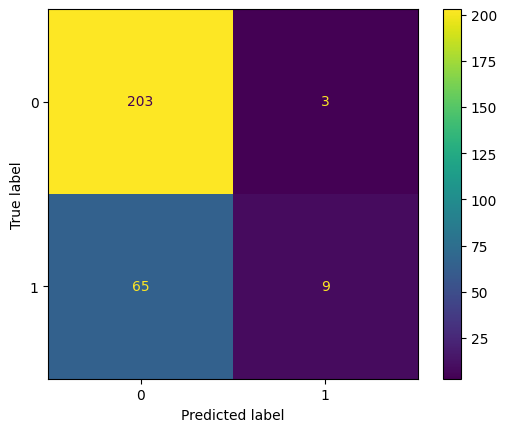

In [61]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_shap_cMatrix, display_labels=CE_FIFS_shap_model.classes_)
disp.plot()
plt.show()

*************
BELOW (POSSIBLY) NOT NECESSARY WHEN ABOVE IS USED
************

In [ ]:
#Classifier results with newtry_feature_importance

In [73]:
#Try####
#Calculate feature importance from shap values by taking mean of absolute shap values for each feature
#Higher absolute shap value indicates greater contribution of that feature to the prediction task
vals= np.abs(CE_shap_values).mean(0)

newtry_feature_importance = pd.DataFrame(list(zip(CP_ER_X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
newtry_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
newtry_feature_importance

,col_name,feature_importance_vals
864,TCGAA,152.318754
886,TCTCG,113.035605
498,CTTAG,98.244182
491,CTGGT,73.192162
942,TGGTG,59.075172
...,...,...
306,CATAG,0.000000
645,GGACC,0.000000
816,TATAA,0.000000
302,CAGTG,0.000000


In [70]:
#View FI values for same amount of features selected in FIFS_shap method
# newtry_feature_importance.head(104)

In [74]:
# Show only feature importances above 0.1

CE_newSHAP_thres_chosen = newtry_feature_importance[newtry_feature_importance["feature_importance_vals"] > 0]
CE_newshap_num_chosen = len(CE_newSHAP_thres_chosen)

print(CE_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CE_newshap_num_chosen)

     col_name  feature_importance_vals
864     TCGAA               152.318754
886     TCTCG               113.035605
498     CTTAG                98.244182
491     CTGGT                73.192162
942     TGGTG                59.075172
...       ...                      ...
806     TAGCG                 0.251244
1020    TTTTA                 0.218695
206     ATATG                 0.211077
295     CAGCT                 0.182342
166     AGGCG                 0.041614

[987 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 987


In [75]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importance_vals))
print("Sum of feature importances >=0.1: ", sum(CE_newSHAP_thres_chosen.feature_importance_vals))

Sum of total feature importances:  6498.225728911477
Sum of feature importances >=0.1:  6498.225728911477


In [77]:
# Select features with importance values above 0.1

CE_newshap_selected_feat = newtry_feature_importance[:CE_newshap_num_chosen]['col_name'].tolist()

# print(CE_newshap_selected_feat)

In [78]:
CP_ER_X_train.shape

(1120, 1024)

In [79]:
# See original training set

CP_ER_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.004570,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003127,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003127,0.001924,0.001203,0.002405,0.001443


In [80]:
#Create training set with selected features 

CE_X_train_newshap_selected = CP_ER_X_train[CE_newshap_selected_feat]
CE_X_train_newshap_selected.head()

,TCGAA,TCTCG,CTTAG,CTGGT,TGGTG,CAAGC,TTTGC,AGAAG,CCTGG,GGGTT,...,AAATT,ACCCT,CAGGC,TAAAG,GCAAC,TAGCG,TTTTA,ATATG,CAGCT,AGGCG
0,0.000158,0.000792,0.000475,0.000634,0.001109,0.001426,0.001109,0.001742,0.002059,0.000475,...,0.001901,0.000475,0.000317,0.001742,0.001584,0.000000,0.001584,0.000792,0.001901,0.000475
1,0.000583,0.000583,0.000000,0.000874,0.001748,0.000583,0.000291,0.004079,0.004953,0.000291,...,0.000000,0.002622,0.001748,0.000291,0.000583,0.000000,0.000291,0.000583,0.001457,0.001166
2,0.000458,0.000458,0.000917,0.001375,0.001375,0.000458,0.000458,0.002291,0.003208,0.000917,...,0.000458,0.002750,0.003208,0.000917,0.000000,0.000458,0.000917,0.000458,0.003208,0.000000
3,0.000000,0.000000,0.000990,0.000495,0.001484,0.001484,0.000000,0.000990,0.005443,0.000990,...,0.000495,0.000000,0.002969,0.000000,0.001484,0.000000,0.000495,0.000000,0.002474,0.001484
4,0.000104,0.000415,0.000933,0.000415,0.001451,0.000933,0.000933,0.001659,0.001140,0.001555,...,0.002695,0.000726,0.000933,0.001244,0.001140,0.000000,0.002695,0.001762,0.002281,0.000311


In [81]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CE_X_train_newshap_selected.columns) == CE_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [82]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CE_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_ER_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1120, 987)
Shape of y_train (number of labels): (1120,)


In [83]:
# Create pool object for selected feature data
print("Original number of features:", len(CE_feature_names), "\n Number of selected features:", len(CE_newshap_selected_feat))

CE_newshap_selected_train_pool = Pool(CE_X_train_newshap_selected, CP_ER_y_train, feature_names=CE_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 987


In [84]:
#Create new model for data with selected features
CE_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CE_FIFS_newshap_model.fit(CE_newshap_selected_train_pool)

Learning rate set to 0.079585
0:	learn: 0.6740823	total: 252ms	remaining: 4m 11s
1:	learn: 0.6503764	total: 392ms	remaining: 3m 15s
2:	learn: 0.6294382	total: 528ms	remaining: 2m 55s
3:	learn: 0.6143805	total: 655ms	remaining: 2m 43s
4:	learn: 0.5947276	total: 791ms	remaining: 2m 37s
5:	learn: 0.5806948	total: 930ms	remaining: 2m 34s
6:	learn: 0.5679427	total: 1.06s	remaining: 2m 30s
7:	learn: 0.5568848	total: 1.19s	remaining: 2m 27s
8:	learn: 0.5458080	total: 1.33s	remaining: 2m 26s
9:	learn: 0.5352455	total: 1.46s	remaining: 2m 24s
10:	learn: 0.5252260	total: 1.61s	remaining: 2m 24s
11:	learn: 0.5155585	total: 1.74s	remaining: 2m 23s
12:	learn: 0.5066153	total: 1.88s	remaining: 2m 22s
13:	learn: 0.4984279	total: 2s	remaining: 2m 20s
14:	learn: 0.4916835	total: 2.13s	remaining: 2m 20s
15:	learn: 0.4848284	total: 2.26s	remaining: 2m 18s
16:	learn: 0.4769818	total: 2.37s	remaining: 2m 17s
17:	learn: 0.4698186	total: 2.53s	remaining: 2m 17s
18:	learn: 0.4651795	total: 2.66s	remaining: 2m

In [85]:
#Check parameters used in this model fit

CE_FIFS_newshap_params = CE_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CE_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.079585000872612, '

In [86]:
#Prediction using X_test only for selected features data
CE_FIFS_newshap_y_pred = CE_FIFS_newshap_model.predict(CP_ER_X_test)

#Predication probability for selected features data

CE_FIFS_newshap_y_prob = CE_FIFS_newshap_model.predict_proba(CP_ER_X_test)

In [87]:
# Calculate F1 score and get classification report

CE_FIFS_newshap_f1 = f1_score(CP_ER_y_test, CE_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CE_FIFS_newshap_f1}")

CE_FIFS_newshap_cr = classification_report(CP_ER_y_test, CE_FIFS_newshap_y_pred, digits=3)
print(CE_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_ER_y_test, CE_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_ER_y_test, CE_FIFS_newshap_y_prob))

F1 Score: 0.5305095866443099
              precision    recall  f1-score   support

           0      0.757     0.981     0.854       206
           1      0.692     0.122     0.207        74

    accuracy                          0.754       280
   macro avg      0.724     0.551     0.531       280
weighted avg      0.740     0.754     0.683       280

Accuracy score:  0.7535714285714286


In [88]:
# Confusion matrix for selected data

print("real values shape:", CP_ER_y_test.shape)
print("prediction shape:", CE_FIFS_newshap_y_pred.shape)

CE_FIFS_newshap_y_pred_fl = CE_FIFS_newshap_y_pred
print("flattened prediction values shape:", CE_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CE_FIFS_newshap_cMatrix = confusion_matrix(CP_ER_y_test, CE_FIFS_newshap_y_pred_fl)
print(CE_FIFS_newshap_cMatrix)

real values shape: (280,)
prediction shape: (280, 1)
flattened prediction values shape: (280,) 

[[202   4]
 [ 65   9]]


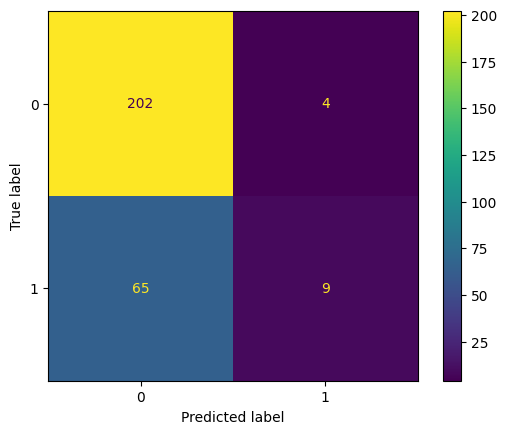

In [89]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CE_FIFS_newshap_cMatrix, display_labels=CE_FIFS_newshap_model.classes_)
disp.plot()
plt.show()